# - Importing Libraries

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, classification_report

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import neural_network

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from svm import MultiClassSVM
from boosting import GradientBoosting
#from random_forest import RandomForest # Functional classifier, just runs much more slowly than sklearn RandomForestClassifier

kingdoms = ['arc', 'plm', 'rod', 'phg', 'pri', 'vrt', 'bct', 'pln', 'inv', 'mam', 'vrl']
kingdom_names = ['archaea', 'plasmid', 'rodent', 'bacteriophage', 'primate', 'vertebrate', 'bacteria', 'plant', 'invertebrate', 'mammal', 'virus']

# - Preparing The Data

In [7]:
def preprocess(file_path: str, test_size: float = 0.2, random_state: int = 42, split: bool = True) -> tuple:
    # Load the data
    codon_usage_df = pd.read_csv(file_path, low_memory=False)

    # Extracting the codon frequency columns and converting to numeric, coercing errors to NaN
    codon_columns = codon_usage_df.columns[5:]
    X = codon_usage_df[codon_columns].apply(pd.to_numeric, errors='coerce')
    y = codon_usage_df['Kingdom']

    # Drop rows with any NaN values in X and filter y accordingly
    X_clean = X.dropna()
    y_clean = y.loc[X_clean.index]

    scaler = StandardScaler()

    if split:
        # Splitting the data
        X_train, X_test, y_train, y_test = train_test_split(X_clean, y_clean, test_size=test_size, random_state=random_state)
    else:
        X_train, y_train = X_clean, y_clean

    # Standardize the data
    X_train_scaled = scaler.fit_transform(X_train)

    if split:
        X_test_scaled = scaler.transform(X_test)
    
    if split:
        return(X_train_scaled, X_test_scaled, y_train, y_test)
    else:
        return(X_train_scaled, y_train)

X_train, X_test, y_train, y_test = preprocess('codon_usage.csv', test_size=0.2, random_state=42)

# - Helper Functions

In [8]:
def train_classify(classifier):
    # A valid classifier object presents the fit(numpy.ndarray, pandas.Series) -> None and predict(pandas.Series) -> numpy.ndarray functions
    print('\nTraining...\n')

    # Training the chosen classifier
    classifier.fit(X_train, y_train)

    # Making predictions
    y_pred = classifier.predict(X_test)

    # Evaluating the model
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy: {:.2f}%".format(accuracy * 100))
    print('Classification Report:\n', classification_report(y_test, y_pred, zero_division=0))

def kingdom_to_color(kingdom: str):
    color = {
        'arc': (0, 0, 0),
        'plm': (125, 125, 125),
        'rod': (255, 0, 0),
        'phg': (0, 255, 0),
        'pri': (0, 0, 255),
        'vrt': (0, 125, 125),
        'bct': (125, 0, 125),
        'pln': (125, 125, 0),
        'inv': (0, 255, 255),
        'mam': (255, 0, 255),
        'vrl': (255, 165, 0),
    }[kingdom]
    return(color[0] / 255, color[1] / 255, color[2] / 255)

def visualize(visualizer, title: str, data = 'all'):
    if data == 'all':
        X, y = preprocess('codon_usage.csv', random_state=42, split=False)
    else:
        X, y = data
    X_transformed =  visualizer.fit_transform(X)
    plt.title(title)
    plt.scatter(X_transformed[:, 0], X_transformed[:, 1], c=pd.Series(y).apply(kingdom_to_color), s=3)
    plt.xlabel("Reduced Dimension 1")
    plt.ylabel("Reduced Dimension 2")

    handles = [mpatches.Patch(color=kingdom_to_color(kingdom), label=kingdom) for kingdom in kingdoms]
    plt.legend(handles, kingdom_names, ncol=1, bbox_to_anchor=(1, 1))

    plt.show()

def visualize_misclassified(visualizer, visualizer_name: str, classifier, classifier_name: str):
    incorrect_classifications = []
    misclassified = []
    incorrect_data = []
    index = 0
    for ground_truth, prediction in zip(y_test, classifier.predict(X_test)):
        if ground_truth != prediction:
            incorrect_data.append(X_test[index])
            misclassified.append(ground_truth)
            incorrect_classifications.append(prediction)
        index += 1
    incorrect_classifications = np.array(incorrect_classifications)
    visualize(visualizer, visualizer_name + ' of ' + classifier_name + ' Misclassified Predictions', data=(np.array(incorrect_data), np.array(incorrect_classifications)))
    visualize(visualizer, visualizer_name + ' of ' + classifier_name + ' Misclassified Ground Truth', data=(np.array(incorrect_data), np.array(misclassified)))


# - PCA Visualization

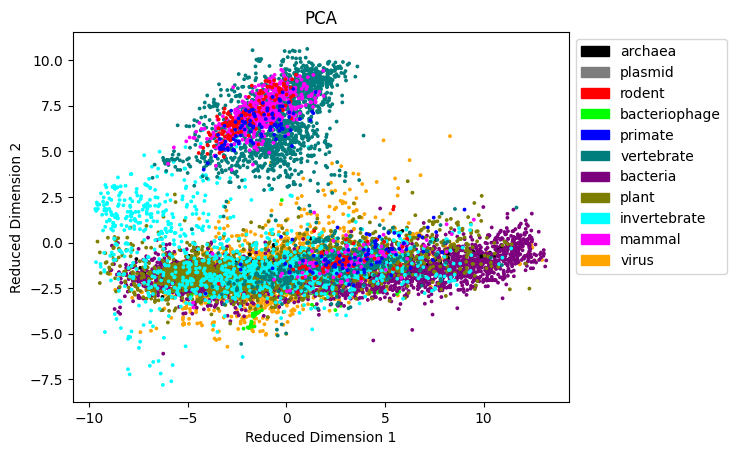

In [9]:
visualize(PCA(n_components=2), 'PCA')

# - t-SNE Visualization

/Users/cyw/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/cyw/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


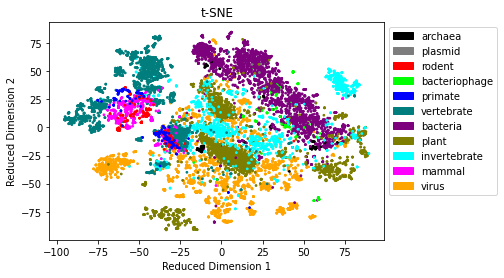

In [26]:
visualize(TSNE(n_components=2), 't-SNE')

# - Evaluating Different Classifiers

### 1. Random Forest Classifier


Training...

Accuracy: 89.03%
Classification Report:
               precision    recall  f1-score   support

         arc       0.91      0.43      0.59        23
         bct       0.90      0.96      0.93       604
         inv       0.89      0.70      0.79       291
         mam       0.88      0.80      0.84       112
         phg       0.92      0.50      0.65        46
         plm       0.00      0.00      0.00         5
         pln       0.87      0.92      0.89       495
         pri       0.91      0.50      0.65        40
         rod       0.90      0.70      0.79        40
         vrl       0.88      0.95      0.92       575
         vrt       0.91      0.96      0.93       375

    accuracy                           0.89      2606
   macro avg       0.82      0.68      0.72      2606
weighted avg       0.89      0.89      0.88      2606



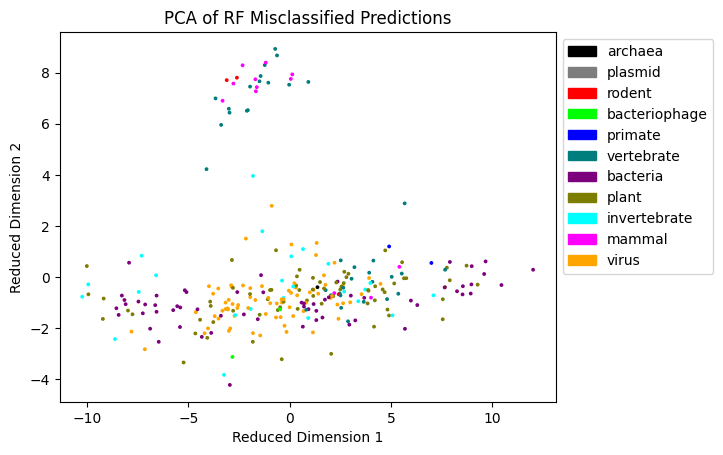

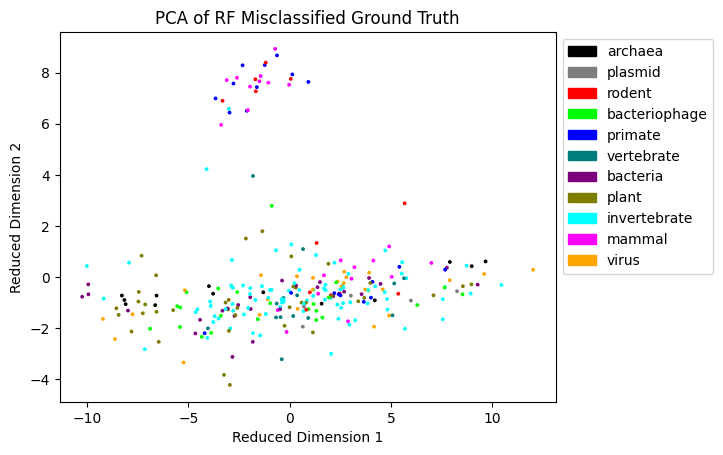

In [10]:
classifier = RandomForestClassifier(n_estimators=100, random_state=42)
#classifier = RandomForest(n_estimators=100, max_depth=10, sample_size_ratio=0.8)
train_classify(classifier)
visualize_misclassified(PCA(n_components=2), 'PCA', classifier, 'RF')

### 2. K-Neighbors Classifier


Training...

Accuracy: 92.13%
Classification Report:
               precision    recall  f1-score   support

         arc       0.79      0.65      0.71        23
         bct       0.93      0.96      0.94       604
         inv       0.92      0.79      0.85       291
         mam       0.88      0.88      0.88       112
         phg       0.76      0.76      0.76        46
         plm       1.00      0.40      0.57         5
         pln       0.91      0.95      0.93       495
         pri       0.71      0.75      0.73        40
         rod       0.73      0.88      0.80        40
         vrl       0.96      0.94      0.95       575
         vrt       0.95      0.97      0.96       375

    accuracy                           0.92      2606
   macro avg       0.87      0.81      0.83      2606
weighted avg       0.92      0.92      0.92      2606



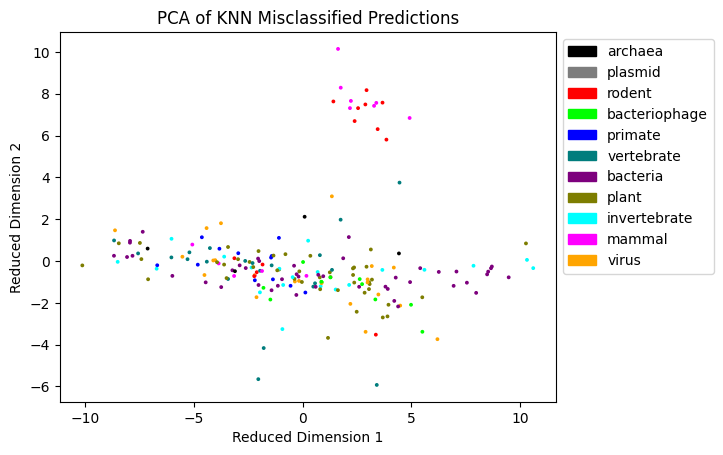

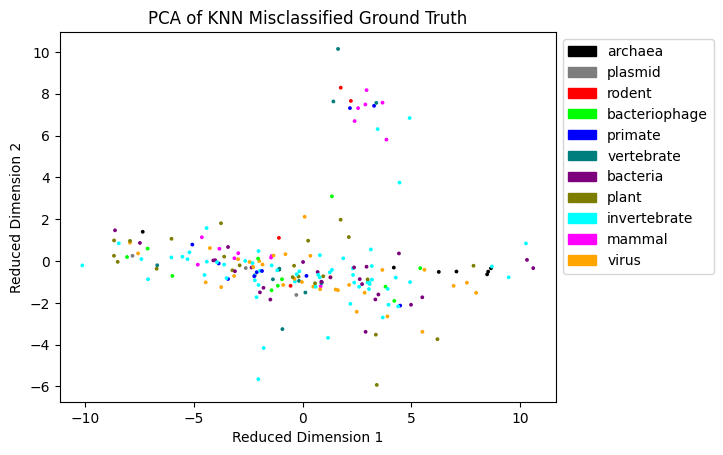

In [11]:
classifier = KNeighborsClassifier(n_neighbors=1) # Increasing n_neighbors consistently decreases accuracy and most f1-scores
train_classify(classifier)
visualize_misclassified(PCA(n_components=2), 'PCA', classifier, 'KNN')

### 3. Neural Network


Training...

Accuracy: 89.60%
Classification Report:
               precision    recall  f1-score   support

         arc       0.52      0.52      0.52        23
         bct       0.93      0.92      0.93       604
         inv       0.86      0.78      0.82       291
         mam       0.85      0.84      0.84       112
         phg       0.65      0.65      0.65        46
         plm       0.00      0.00      0.00         5
         pln       0.87      0.95      0.90       495
         pri       0.69      0.55      0.61        40
         rod       0.56      0.72      0.63        40
         vrl       0.95      0.94      0.95       575
         vrt       0.96      0.94      0.95       375

    accuracy                           0.90      2606
   macro avg       0.71      0.71      0.71      2606
weighted avg       0.90      0.90      0.89      2606



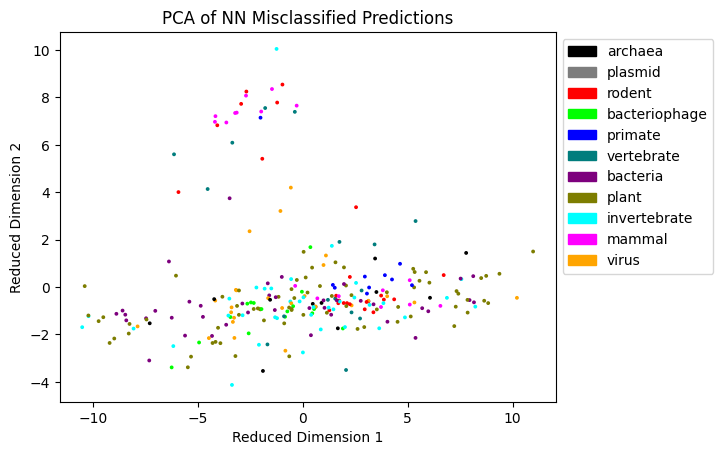

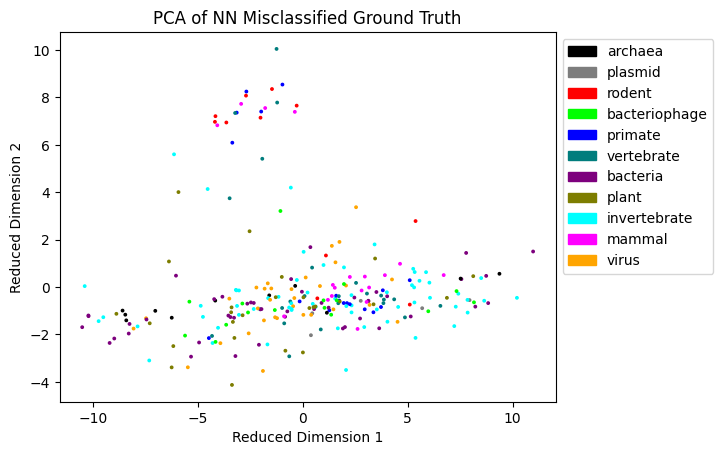

In [12]:
classifier = neural_network.neural_network(input_size=X_train.shape[1], output_size=len(kingdoms), categories=kingdoms,
    #hidden_layers = [64, 48, 32, 16, 8], learning_rate=0.05 # 88 f1 accuracy / 62 f1 macro avg
    #hidden_layers = [64, 48, 32, 16, 8], learning_rate=0.2 # 87/63
    #hidden_layers = [64, 48, 32, 16, 8], learning_rate=0.2 # 88/65
    #hidden_layers = [64, 64, 64, 64, 64], learning_rate=0.05, train_epochs=20 # 88/67
    #hidden_layers = [64, 64, 64, 64, 64], learning_rate=0.05, train_epochs=40 # 88/70
    #hidden_layers = [64, 64, 64, 64, 64, 64], learning_rate=0.05, train_epochs=40 # 89/68
    hidden_layers = [64, 64, 64, 64, 64, 64], learning_rate=0.05, train_epochs=80 # 89/72, best so far
    #hidden_layers = [64, 64, 64, 64, 64, 64], learning_rate=0.05, train_epochs=160 # 88/72, seems to converge by 80 epochs
    #hidden_layers = [64, 72, 80, 88, 96, 102], learning_rate=0.05, train_epochs=40 # 85/61, takes much longer to run
)
train_classify(classifier)
visualize_misclassified(PCA(n_components=2), 'PCA', classifier, 'NN')

### 4. SVM Classifier


Training...

Accuracy: 80.58%
Classification Report:
               precision    recall  f1-score   support

         arc       0.71      0.52      0.60        23
         bct       0.86      0.93      0.90       604
         inv       0.82      0.41      0.55       291
         mam       0.72      0.65      0.69       112
         phg       0.82      0.30      0.44        46
         plm       0.00      0.00      0.00         5
         pln       0.76      0.86      0.81       495
         pri       0.54      0.17      0.26        40
         rod       0.85      0.28      0.42        40
         vrl       0.85      0.93      0.89       575
         vrt       0.82      0.92      0.86       375

    accuracy                           0.81      2606
   macro avg       0.70      0.54      0.58      2606
weighted avg       0.81      0.81      0.79      2606



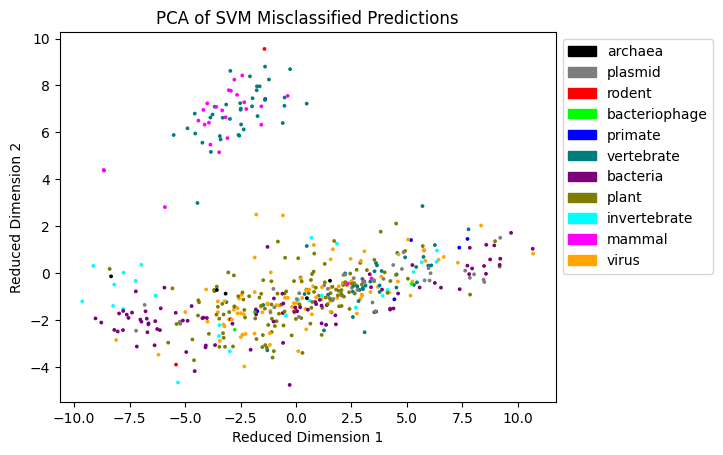

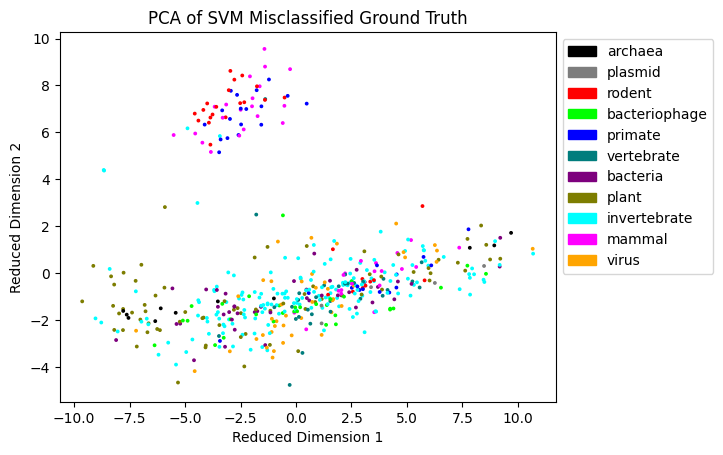

In [ ]:
classifier = MultiClassSVM(learning_rate=0.0005, lambda_param=0.001, n_iters=1000)
train_classify(classifier)
visualize_misclassified(PCA(n_components=2), 'PCA', classifier, 'SVM')

### 5. Gradient Boosting Classifier


Training...

Accuracy: 88.49%
Classification Report:
               precision    recall  f1-score   support

         arc       0.85      0.48      0.61        23
         bct       0.93      0.93      0.93       604
         inv       0.86      0.70      0.77       291
         mam       0.84      0.78      0.81       112
         phg       0.81      0.54      0.65        46
         plm       0.00      0.00      0.00         5
         pln       0.84      0.93      0.88       495
         pri       0.82      0.45      0.58        40
         rod       0.77      0.68      0.72        40
         vrl       0.91      0.96      0.93       575
         vrt       0.89      0.96      0.92       375

    accuracy                           0.88      2606
   macro avg       0.77      0.67      0.71      2606
weighted avg       0.88      0.88      0.88      2606



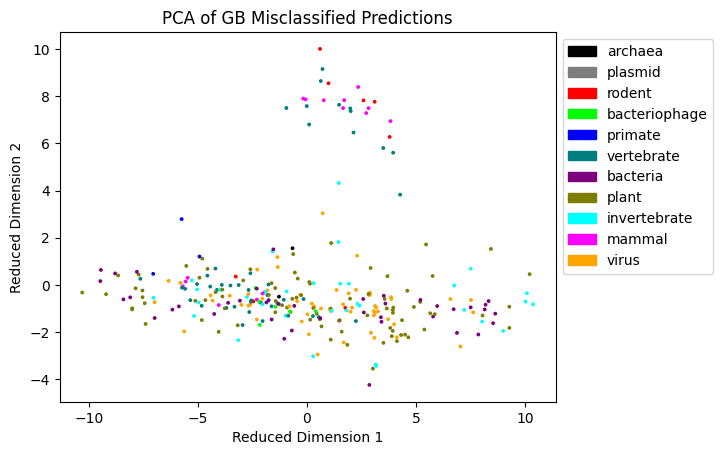

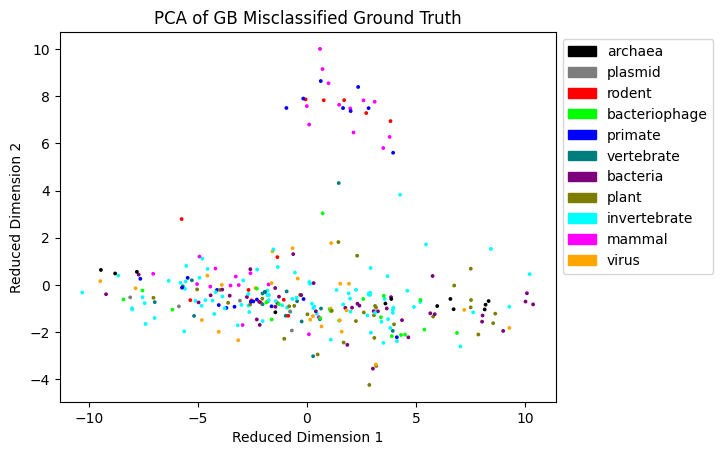

In [ ]:
classifier = GradientBoosting(n_estimators=1000, learning_rate=0.2)
train_classify(classifier)
visualize_misclassified(PCA(n_components=2), 'PCA', classifier, 'GB')